# Modelamiento
Tras explorar en detenimiento los datos y tener claras la preguntas de negocio se procede a generar un modelo (regresivo)

### Librerías

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Importación de datos limpios y breve exploración

In [9]:
# df = pd.read_csv("Repositorio-Proyecto1\Ingeniería y análisis de datos\data_limpia.csv")
df = pd.read_csv("data_limpia.csv")
df.head()

,category,bathrooms,bedrooms,has_photo,price,price_display,price_type,square_feet,cityname,state,latitude,longitude,time
0,housing/rent/apartment,1.0,0.0,Thumbnail,790,790,Monthly,101,Washington,DC,389057.0,-769861.0,1577359415
1,housing/rent/apartment,1.0,1.0,Thumbnail,425,425,Monthly,106,Evansville,IN,379680.0,-876621.0,1577017063
2,housing/rent/apartment,1.0,0.0,Thumbnail,1390,1.39,Monthly,107,Arlington,VA,388910.0,-770816.0,1577359410
3,housing/rent/apartment,1.0,0.0,Thumbnail,925,925,Monthly,116,Seattle,WA,476160.0,-1223275.0,1576667743
4,housing/rent/apartment,1.0,0.0,Thumbnail,880,880,Monthly,125,Arlington,VA,388738.0,-771055.0,1577359401


In [10]:
df.describe()

,bathrooms,bedrooms,price,square_feet,latitude,longitude,time
count,9917.000000,9917.000000,9917.000000,9917.000000,9917.000000,9.917000e+03,9.917000e+03
mean,1.379097,1.743471,1486.055864,945.903499,376834.312796,-9.462911e+05,1.574871e+09
std,0.615455,0.941908,1078.397223,657.251935,55105.576026,1.581312e+05,3.771848e+06
min,1.000000,0.000000,200.000000,101.000000,213155.000000,-1.580221e+06,1.568744e+09
25%,1.000000,1.000000,949.000000,649.000000,336683.000000,-1.018587e+06,1.568781e+09
50%,1.000000,2.000000,1270.000000,802.000000,387555.000000,-9.365160e+05,1.577358e+09
75%,2.000000,2.000000,1695.000000,1100.000000,413712.000000,-8.187790e+05,1.577359e+09
max,8.500000,9.000000,52500.000000,40000.000000,615940.000000,-7.019160e+05,1.577362e+09


### Visualización y correlación

<Axes: >

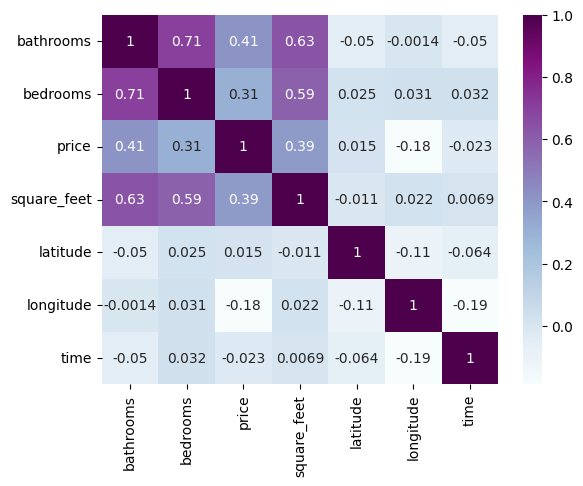

In [17]:
numeric_df = df.select_dtypes(include=[np.number]) 
sns.heatmap(numeric_df.corr(), cmap="BuPu", annot=True)

<Axes: >

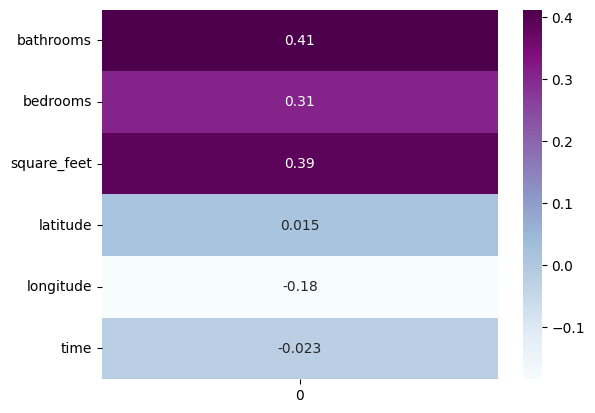

In [19]:
corr_price = numeric_df.drop(['price'], axis=1).corrwith(numeric_df['price'])
sns.heatmap(pd.DataFrame(corr_price), cmap="BuPu", annot=True)